In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
from torch import nn  #nn中有大量定义好的神经网络的层
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [3]:
##导入数据
data = pd.read_csv('E:\实验数据\python\May_data\data.csv')
data = data.values

##转换成array
data_array = data.astype('double')

input_data = data_array[:, :-1]
height_data = data_array[:, [-1]]


In [4]:
##归一化
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

input_data = x_scaler.fit_transform(input_data)
height_data = y_scaler.fit_transform(height_data)

In [5]:
#转换成tensor
input_total = torch.tensor(input_data,dtype=torch.float32)     #只经过归一化的原始数据集
height_labels = torch.tensor(height_data,dtype=torch.float32)
print(input_total.shape)
print(height_labels.shape)

torch.Size([1499, 5])
torch.Size([1499, 1])


In [6]:
torch.manual_seed(42)
 
class RBFN(nn.Module):
    """
    以高斯核作为径向基函数
    """
    def __init__(self, centers, n_out=3):
        """
        :param centers: shape=[center_num,data_dim]
        :param n_out:
        """
        super(RBFN, self).__init__()
        self.n_out = n_out
        self.num_centers = centers.size(0) # 隐层节点的个数
        self.dim_centure = centers.size(1) # 
        self.centers = nn.Parameter(centers)
        # self.beta = nn.Parameter(torch.ones(1, self.num_centers), requires_grad=True)
        self.beta = torch.ones(1, self.num_centers)*10
        # 对线性层的输入节点数目进行了修改
        self.linear = nn.Linear(self.num_centers+self.dim_centure, self.n_out, bias=True)
        self.initialize_weights()# 创建对象时自动执行
 
 
    def kernel_fun(self, batches):
        n_input = batches.size(0)  # number of inputs
        A = self.centers.view(self.num_centers, -1).repeat(n_input, 1, 1)
        B = batches.view(n_input, -1).unsqueeze(1).repeat(1, self.num_centers, 1)
        C = torch.exp(-self.beta.mul((A - B).pow(2).sum(2, keepdim=False)))
        return C
 
    def forward(self, batches):
        radial_val = self.kernel_fun(batches)
        class_score = self.linear(torch.cat([batches, radial_val], dim=1))
        return class_score
 
    def initialize_weights(self, ):
        """
        网络权重初始化
        :return:
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
 
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        print(self)
        print('Total number of parameters: %d' % num_params)
        

In [7]:
k = 4
kmodel = KMeans(n_clusters = k).fit(input_data)   ##对输入数据进行 K-Means聚类
# kmodel.cluster_centers_    ##这个存放了结果的中心点
# print(kmodel.labels_ )     ##这个存放了每个点的分类

#计算两个向量的欧式距离, 输入一定要是同纬度的 np.array 类型的向量  
def distance(vector_A, vector_B):
    dis = vector_A - vector_B
    dis = np.sum((dis**2))**0.5
    return dis

In [14]:
##@算一下每一类点距离中心点的均值, 设定一个边界距离, 大于这个距离的点都筛掉

res = np.zeros(k)  ##存放每个类的数据点距离中心点的距离之和
cnt = np.zeros(k)  ##存放每个类的数据点的个数
for i in range(height_data.shape[0]):
    dot_type = kmodel.labels_[i]
    res[dot_type] = res[dot_type] + distance(kmodel.cluster_centers_[dot_type], input_data[i])
    cnt[dot_type] = cnt[dot_type] + 1

boundary_distance = res / cnt   ## 计算边界距离

k_means_data = []    ##用来保存经过筛除后的输入数据, 定义成list方便添加元素, 之后转换成np.array
k_means_height = []  ##用来保存经过筛除后的高度
##筛点
for i in range(height_data.shape[0]):
    dot_type = kmodel.labels_[i]
    if (distance(input_data[i], kmodel.cluster_centers_[dot_type])) < (boundary_distance[dot_type]*3):
            k_means_data.append(input_data[i])
            k_means_height.append(height_data[i])

k_means_data = np.array(k_means_data)
k_means_height = np.array(k_means_height)

k_means_data = torch.tensor(k_means_data, dtype=torch.float32)    ##将经过筛除的数据转换成tensor 准备打包成数据迭代器, 送入神经网络
k_means_height = torch.tensor(k_means_height, dtype=torch.float32)
print(k_means_data.shape)

torch.Size([1499, 5])


In [15]:
centers = torch.tensor(kmodel.cluster_centers_, dtype=torch.float32)   #这里使用聚类的结果作为 RBF的初始值
# centers = input_total[0:4,:]

In [16]:
horizen = 1  ##向后预测1个点
rbf = RBFN(centers,1) 
params = rbf.parameters()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params,lr=0.01,momentum=0.9)

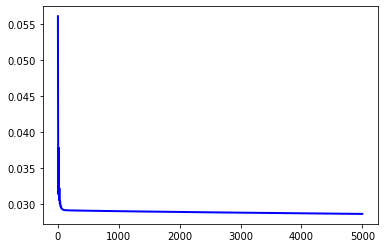

In [17]:
epochs = 5000
plot_loss = torch.zeros(epochs)
for i in range(epochs):
        optimizer.zero_grad()
        y = rbf.forward(k_means_data.data)
        loss = loss_fn(y,k_means_height)
        loss.backward()
        optimizer.step()
#         print(i,"\t",loss.data)
        plot_loss[i] = loss
plt.plot(plot_loss.detach().numpy(), linestyle='-', color='blue', linewidth=2, label='loss')


In [18]:
# 加载使用
# y = rbf.forward(k_means_data)

plt.figure(figsize=(20, 10))
y = rbf.forward(input_total)   #用所有数据进行检验
show_labels = y_scaler.inverse_transform(height_labels)  #反归一化
y = y_scaler.inverse_transform(y.detach().numpy())


error = y - show_labels
rmse = np.mean(error ** 2) ** 0.5
print("rmse: ", rmse)

rmse:  1.0922213091616504


<Figure size 1440x720 with 0 Axes>

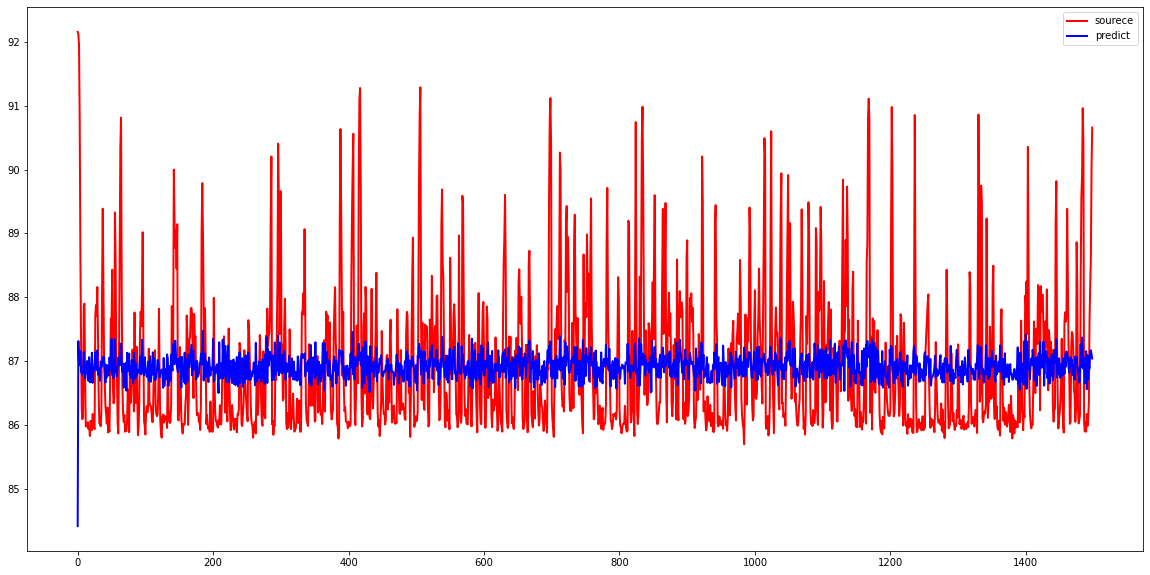

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(show_labels, linestyle='-', color='red', linewidth=2, label='sourece')
plt.plot(y.data,linestyle='-', color='blue', linewidth=2, label='predict')
plt.legend()

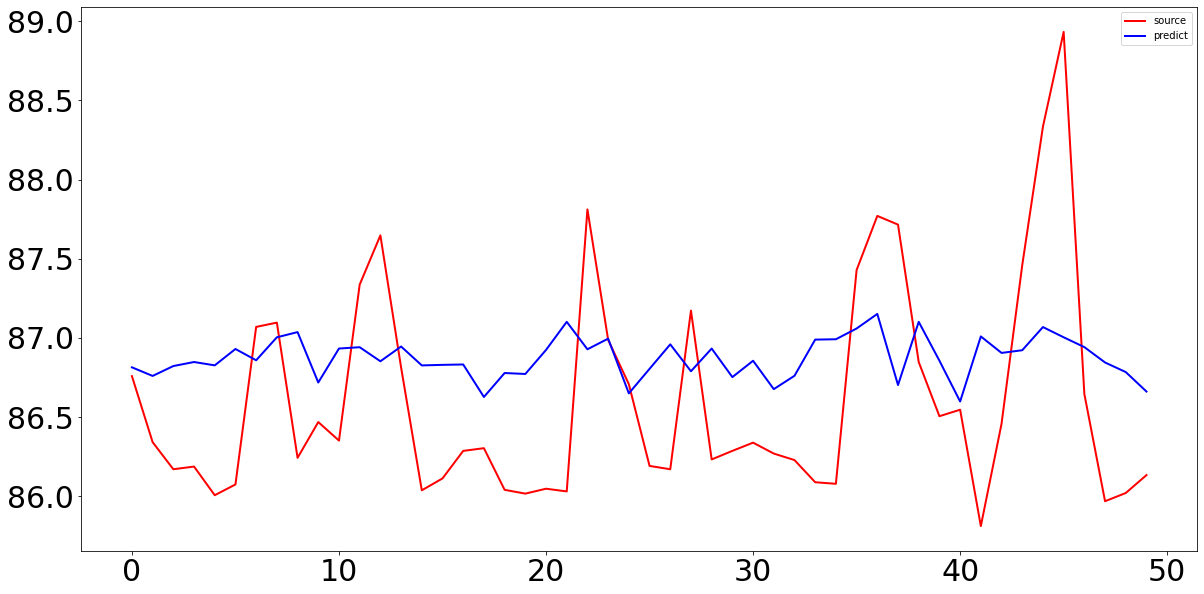

In [20]:
plt.figure(figsize=(20, 10))
experment = 10
show_plot = show_labels[(experment - 1) * 50:50*experment]
onestep_preds_csv = y[(experment - 1) * 50:50*experment]

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.plot(show_plot, linestyle='-', color='red', linewidth=2, label='source')
plt.plot(onestep_preds_csv, linestyle='-', color='blue', linewidth=2, label='predict')
plt.legend(fontsize=200)

plt.legend()